# Convolutional Neural Network (CNN)
- Zwei verschiedene Arten von Convolutional Neural Networks (CNNs) werden in diesem Notebook implementiert.
    - CNN mit kausaler Faltung, d.h. die Ausgabe/Vorhersage hängt nur von der Vergangenheit ab.
    - CNN mit normaler Faltung, d.h. die Ausgabe/Vorhersage hängt von der Zukunft und der Vergangenheit ab.

Bei der Erstellung des Codes wurde sich an den folgenden Quellen orientiert:
- https://medium.com/@oluyaled/audio-classification-using-deep-learning-and-tensorflow-a-step-by-step-guide-5327467ee9ab
- https://www.tensorflow.org/tutorials/images/cnn
- https://wandb.ai/mostafaibrahim17/ml-articles/reports/An-Introduction-to-Audio-Classification-with-Keras--Vmlldzo0MDQzNDUy

# 1. Schritt: Audio-Dateien laden und in Spektrogramme umwandeln

In [28]:
from pathlib import Path
import os

import librosa
import numpy as np
import tensorflow as tf


def convert_audio_files_to_mel_spectrogram(data_path: str,
                                           labels_dict: dict) -> tuple:
    """Konvertiert die Audio-Dateien in Mel-Spektrogramme.

    :param data_path: Pfad zu dem Hauptverzeichnis, in dem die Audio-Dateien
    liegen
    :param labels_dict: Dictionary, das die Labels den Ordnernamen zuordnet
    :return: Mel-Spektrogramme und Labels
    """
    labels, mels = [], []
    for label, folder in labels_dict.items():
        folder_path = Path(data_path) / folder
        # Zieldimensionen der Spektrogramme d.h Größe der Bilder (128x128 Pixel)
        target_shape = (128, 128)

        for file in os.listdir(folder_path):
            file_path = Path(folder_path) / file

            # Lade die Audiodatei (Original-Sampling-Rate beibehalten sr=None)
            audio_data, sample_rate = librosa.load(file_path, sr=None)

            # Berechne das Mel-Spektrogramm
            mel_spectrogram = librosa.feature.melspectrogram(
                y=audio_data, sr=sample_rate
            )

            # Wandle das Spektrogramm in Dezibel um (logarithmische Skala)
            # Notwendig um großen Unterschiede (kleine/größere Werte)
            # in den Spektrogrammen auszugleichen
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

            # Füge eine Kanal-Dimension hinzu (Höhe, Breite, Kanal)
            mel_spectrogram = np.expand_dims(mel_spectrogram, axis=-1)

            # Skaliere das Spektrogramm auf die gewünschte Größe (128x128 Pixel)
            mel_spectrogram = tf.image.resize(mel_spectrogram, target_shape)

            # Mel-Spektrogramm entlang der Höhe oder Breite mitteln
            # um es in eine 1D-Darstellung zu transformieren
            # Mittelwert entlang der Höhe
            mel_spectrogram = np.mean(mel_spectrogram, axis=0)


            mels.append(mel_spectrogram)
            labels.append(label)

            # Mel-Spektrogramm anschauen
            # audio_label = labels_dict[label]
            # librosa.display.waveshow(audio_data, sr=sample_rate)
            # plt.figure(figsize=(10, 4) )
            # plt.title(audio_label)

    return np.array(mels), np.array(labels)


# Pfade zu dem Hauptverzeichnis und den Ordnern mit den Audio-Dateien
data_path = (
    "/Users/paula/Documents/thm/pki/code/data/virufy-data/clinical/segmented/"
)

labels_dict = {0: "neg", 1: "pos"}

# Audio-Dateien laden und in Mel-Spektrogramme konvertieren
mels, labels = convert_audio_files_to_mel_spectrogram(data_path, labels_dict)


# 2. Schritt: Aufteilen der Daten in Trainings- und Testdaten

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Labels in One-Hot-Encoding umwandeln
labels = to_categorical(labels, num_classes=len(labels_dict))

# Train-Test-Split durchführen
mel_train, mel_test, labels_train, labels_test = train_test_split(
    mels, labels, test_size=0.2, random_state=42
)

print(
    f"""mel_train.shape: {mel_train.shape},
    labels_train.shape: {labels_train.shape}"""
)
print(
    f"""mel_test.shape: {mel_test.shape},
    labels_test.shape: {labels_test.shape}"""
)


mel_train.shape: (96, 128, 1),
    labels_train.shape: (96, 2)
mel_test.shape: (25, 128, 1),
    labels_test.shape: (25, 2)


# 3. Schritt: CNN-Modelle erstellen

In [30]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential


def build_cnn(*,include_future: bool) -> Sequential:
    """Erstellt ein CNN-Modell, das auf den Mel-Spektrogrammen trainiert wird.

    :param include_future: Boolean, ob die Zukunft berücksichtigt werden soll
    :return: CNN-Modell (TensorFlow Sequential Model)
    """
    # CNN-Modell wird definiert
    model = Sequential()
    # Eingabeform: (128, 128, 1)
    input_shape = mel_train[0].shape

    padding_value = "valid"
    if not include_future:
        padding_value = "causal"

    # Convolutional-Schicht
    # 32 Filter (Merkmale), Kernelgröße 3, Aktivierungsfunktion ReLU
    model.add(
        Conv1D(
            32, kernel_size=3, activation="relu",
            input_shape=(input_shape), padding=padding_value
        )
    )

    # MaxPooling-Schicht
    # Reduziert die Größe der Ausgabe, indem es die höchsten Werte
    # aus 2 Blöcken auswählt
    model.add(MaxPooling1D(pool_size=2))

    # Convolutional-Schicht
    # 64 Filter (Merkmale), Kernelgröße 3, Aktivierungsfunktion ReLU
    model.add(Conv1D(64, kernel_size=3,
                     activation="relu", padding=padding_value))

    # Wandelt die mehrdimensionale Ausgabe in einen Vektor um
    model.add(Flatten())
    # Dense-Schicht
    # 64 Neuronen, Aktivierungsfunktion ReLU (Führt Klassifizierungslogik durch)
    model.add(Dense(64, activation="relu"))
    # Dropout-Schicht
    # Ausgabeschicht mit einer Neuronanzahl, die der
    # Anzahl der Klassen (2 für positiv/negativ) entspricht.
    model.add(Dense(len(labels_dict), activation="softmax"))
    # model.summary()
    return model


# 3.1. Schritt: CNN mit kausaler Faltung

In [31]:
causal_model = build_cnn(include_future=False)


# 3.2. Schritt: CNN mit normaler Faltung

In [32]:
model = build_cnn(include_future=True)


# 4. Modell kompilieren

In [33]:
# Modelle werden für das Training vorbereitet
# Optimierungsalgorithmus: Adam (Optimierungsalgorithmus) (Wie werden die
# Gewichte angepasst)
# Verlustfunktion: Categorical Crossentropy (Wie werden die Fehler berechnet)
# Metrik: Genauigkeit (Welche Metrik wird zur Bewertung des Modells verwendet)
causal_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)


# 5. Schritt: Modell trainieren

In [34]:
# Modelle werden trainiert
# Anzahl der Epochen: 5 (Wie oft wird das Modell auf den
# Trainingsdaten trainiert)
# Batch-Größe: 32 (Wie viele Beispiele werden gleichzeitig verarbeitet)
# Validierungsdaten: Testdaten (Überprüfung der Performance des Modells auf
# den Testdaten)
history_causal = causal_model.fit(
    mel_train,
    labels_train,
    epochs=10,
    batch_size=32,
    validation_data=(mel_test, labels_test),
)
history = model.fit(
    mel_train,
    labels_train,
    epochs=10,
    batch_size=32,
    validation_data=(mel_test, labels_test),
)


Epoch 1/10


3/3 [==============================] - 0s 69ms/step - loss: 5.8858 - accuracy: 0.6562 - val_loss: 1.2049 - val_accuracy: 0.2800
Epoch 2/10
3/3 [==============================] - 0s 14ms/step - loss: 1.3266 - accuracy: 0.4271 - val_loss: 0.5995 - val_accuracy: 0.7200
Epoch 3/10
3/3 [==============================] - 0s 13ms/step - loss: 0.9434 - accuracy: 0.5729 - val_loss: 0.6588 - val_accuracy: 0.7200
Epoch 4/10
3/3 [==============================] - 0s 14ms/step - loss: 0.7442 - accuracy: 0.4896 - val_loss: 1.1623 - val_accuracy: 0.2800
Epoch 5/10
3/3 [==============================] - 0s 14ms/step - loss: 0.8203 - accuracy: 0.4688 - val_loss: 0.5941 - val_accuracy: 0.7200
Epoch 6/10
3/3 [==============================] - 0s 13ms/step - loss: 0.7016 - accuracy: 0.5729 - val_loss: 0.5966 - val_accuracy: 0.7200
Epoch 7/10
3/3 [==============================] - 0s 13ms/step - loss: 0.6906 - accuracy: 0.6354 - val_loss: 0.7467 - val_accuracy: 0.4000
Epoch 8/10
3/3 [======================

# 6. Evaluation

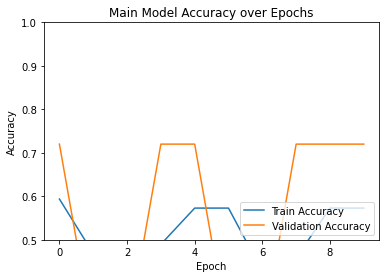

1/1 - 0s - loss: 0.6138 - accuracy: 0.7200 - 28ms/epoch - 28ms/step
Main Model Test Accuracy: 0.7200
Main Model Test Loss: 0.6138


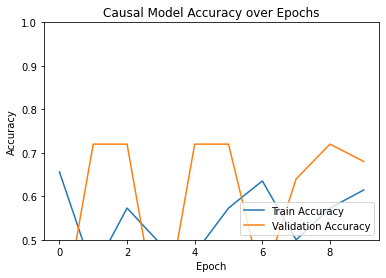

1/1 - 0s - loss: 0.6621 - accuracy: 0.6800 - 17ms/epoch - 17ms/step
Causal Model Test Accuracy: 0.6800
Causal Model Test Loss: 0.6621


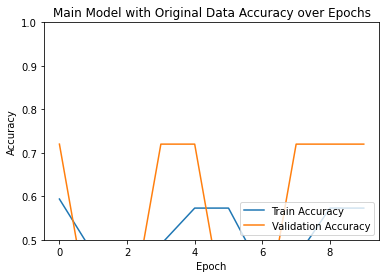

1/1 - 0s - loss: 0.6091 - accuracy: 0.6250 - 17ms/epoch - 17ms/step
Main Model with Original Data Test Accuracy: 0.6250
Main Model with Original Data Test Loss: 0.6091


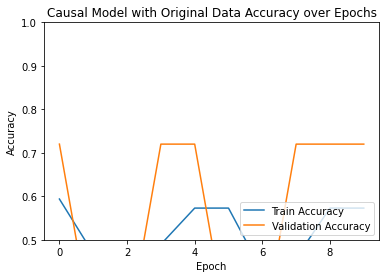

1/1 - 0s - loss: 0.6822 - accuracy: 0.5625 - 17ms/epoch - 17ms/step
Causal Model with Original Data Test Accuracy: 0.5625
Causal Model with Original Data Test Loss: 0.6822


In [35]:
import matplotlib.pyplot as plt


def plot_accuracy_and_evaluate(
    model: Sequential, history: Sequential, mel_test: dict, labels_test: dict,
    model_name: str="Model") -> None:
    """Plottet die Trainings- und Validierungsgenauigkeit.

    :param model: Modell, das evaluiert werden soll
    :param history: Trainingshistorie des Modells
    :param mel_test: Testdaten (Mel-Spektrogramme)
    :param labels_test: Testlabels
    :param model_name: Name des Modells
    """
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0.5, 1])
    plt.title(f"{model_name} Accuracy over Epochs")
    plt.legend(loc="lower right")
    plt.show()

    test_loss, test_acc = model.evaluate(mel_test, labels_test, verbose=2)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} Test Loss: {test_loss:.4f}")


# Beispielaufruf für das Standardmodell
plot_accuracy_and_evaluate(
    model, history, mel_test, labels_test, model_name="Main Model"
)

# Beispielaufruf für das Causal Modell
plot_accuracy_and_evaluate(
    causal_model,
    history_causal,
    mel_test,
    labels_test,
    model_name="Causal Model",
)

# Testen mit den Originaldaten
data_path = (
    "/Users/paula/Documents/thm/pki/code/data/virufy-data/clinical/original/"
)
test_mels, test_labels = convert_audio_files_to_mel_spectrogram(
    data_path, labels_dict
)
test_labels = to_categorical(test_labels, num_classes=len(labels_dict))
mel_test, labels_test = test_mels, test_labels
plot_accuracy_and_evaluate(
    model,
    history,
    mel_test,
    labels_test,
    model_name="Main Model with Original Data",
)
plot_accuracy_and_evaluate(
    causal_model,
    history,
    mel_test,
    labels_test,
    model_name="Causal Model with Original Data",
)
